# Validation of Ruffed Grouse recognition method

This notebook provides the python code to reproduce results from Lapp et al 2022 (in review in the Wilderness Society Bulletin). 

Specifically, this notebook uses an automated recognition method for ruffed grouse (described in the manuscript) to detect ruffed grouse drumming events in a set of 5-minute annotated audio files. It then calculates metrics of the method's performance. 

This notebook was tested with python 3.8 and opensoundscape==0.7.0. OpenSoundscape is an open-source bioacoustics toolkit for python. To install opensoundscape and learn more visit [opensoundscape.org](https://opensoundscape.org)

The data used in this notebook is available through OneDrive at the following link (contact sam.lapp (at) pitt.edu if the link is broken): 

https://pitt-my.sharepoint.com/:f:/g/personal/sml161_pitt_edu/ErSJhcRH3ZFFtEdJt1ndG58B1m8jE-t-zsBz1D2-oAbC9g?e=kNVGfz 

Download the entire folder and move it into the _same folder as this notebook_ on your computer in order to run the analyses yourself. 

### import required packages

In [84]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.signal import find_accel_sequences, cwt_peaks

import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'


### parameters
These parameter choices match those used in the WSB 2022 manuscript and are designed to detect ruffed grouse drumming events 

In [85]:
sr = 400 #resample audio to this sample rate
wavelet = 'morl'
peak_threshold = 0.2 
window_len = 60 #sec to analyze in one chunk
center_frequency = 50 #for cwt
peak_separation = 15/400 #min duration (sec) between peaks

### analysis function
This function takes a path to an audio file and performs the automated drumming recognition on sequential 1-minute clips of audio. 

For details on the methods and parameter choices, see the manuscript. 

In [86]:
def analyze_file(path):
    #load the audio file into an object
    a=Audio.from_file(path,sample_rate=sr)
    
    #initialize an empty dataframe to store detected drumming events
    file_df = pd.DataFrame()

    #initialize lists to store informatino about detections
    window_starts = []
    longest_sweeps = []
    dfs = []

    #loop through each analysis window or chunk of audio data, eg 60 second windows
    for window_idx in range(int(a.duration()/window_len)):
        t = window_idx*window_len #calculate start time of window

        # trim audio to an analysis window
        audio_window = a.trim(t,t+window_len)

        # analyze 1 window at a time using 2 steps:
        
        # 1. find signal peaks with continuous wavelet transform
        pt, _  = cwt_peaks(audio_window,center_frequency,wavelet,peak_threshold=peak_threshold,peak_separation=peak_separation)
        
        # 2. find sequences of peaks that match the accellerating sequence of ruffed grouse drumming
        ch_t, ch_y = find_accel_sequences(
            pt,
            dt_range=[0.05, 0.8],
            dy_range=[-0.2, 0],
            d2y_range=[-0.05, 0.15],
            max_skip=3,
            duration_range=[1, 15],
            points_range=[9, 100],
        )
    
        # save detected sequences ("sweeps")
        longest_sweeps.append(max([len(c) for c in ch_y]) if len(ch_y)>0 else 0)
        window_starts.append(t)

        #aggregate detections into a dataframe
        dfs.append(pd.DataFrame(data={
            'path':[path]*len(ch_y),
            'chain':ch_y,
            'chain_t':ch_t,
            'window_start_t':[t]*len(ch_y)
        }))
    
    #aggregate dataframse from each window 
    file_df = pd.concat(dfs)
    file_df['chain_len']=[len(ch_y) for ch_y in file_df.chain]
    file_df['midpoint_time']=[(t[0]+t[-1])/2 for t in file_df.chain_t]
    file_df['start_time']=[t[0] for t in file_df.chain_t]
    file_df['end_time']=[t[-1] for t in file_df.chain_t]
    file_df = file_df[['path','window_start_t','chain_len','midpoint_time','start_time','end_time']]

    return file_df

## Analyze one file and examine a detection

In [48]:
results_df = analyze_file('./annotated_audio/20200425/LSD-0028/20200425_114000_0s-300s.wav')
results_df

,path,window_start_t,chain_len,midpoint_time,start_time,end_time
0,./annotated_audio/20200425/LSD-0028/20200425_1...,60.0,24,7.921580,5.507729,10.335431
0,./annotated_audio/20200425/LSD-0028/20200425_1...,120.0,22,32.587608,29.878745,35.296471
0,./annotated_audio/20200425/LSD-0028/20200425_1...,240.0,11,1.145048,0.297512,1.992583


```
if you recieve an error, make sure you've downloaded the data and moved the entire folder titled ruffed_grouse_validation_set into the same folder as this notebook
```

We can see that the first detection, which contains 24 pulses in a sequence, begins in the window starting at 60 seconds, and starts 5.5 seconds into that window. Let's look at that section of the audio file as a spectrogram (note that we bandpass the spectrogram to 0-1000 Hz to zoom in on the low frequencies):

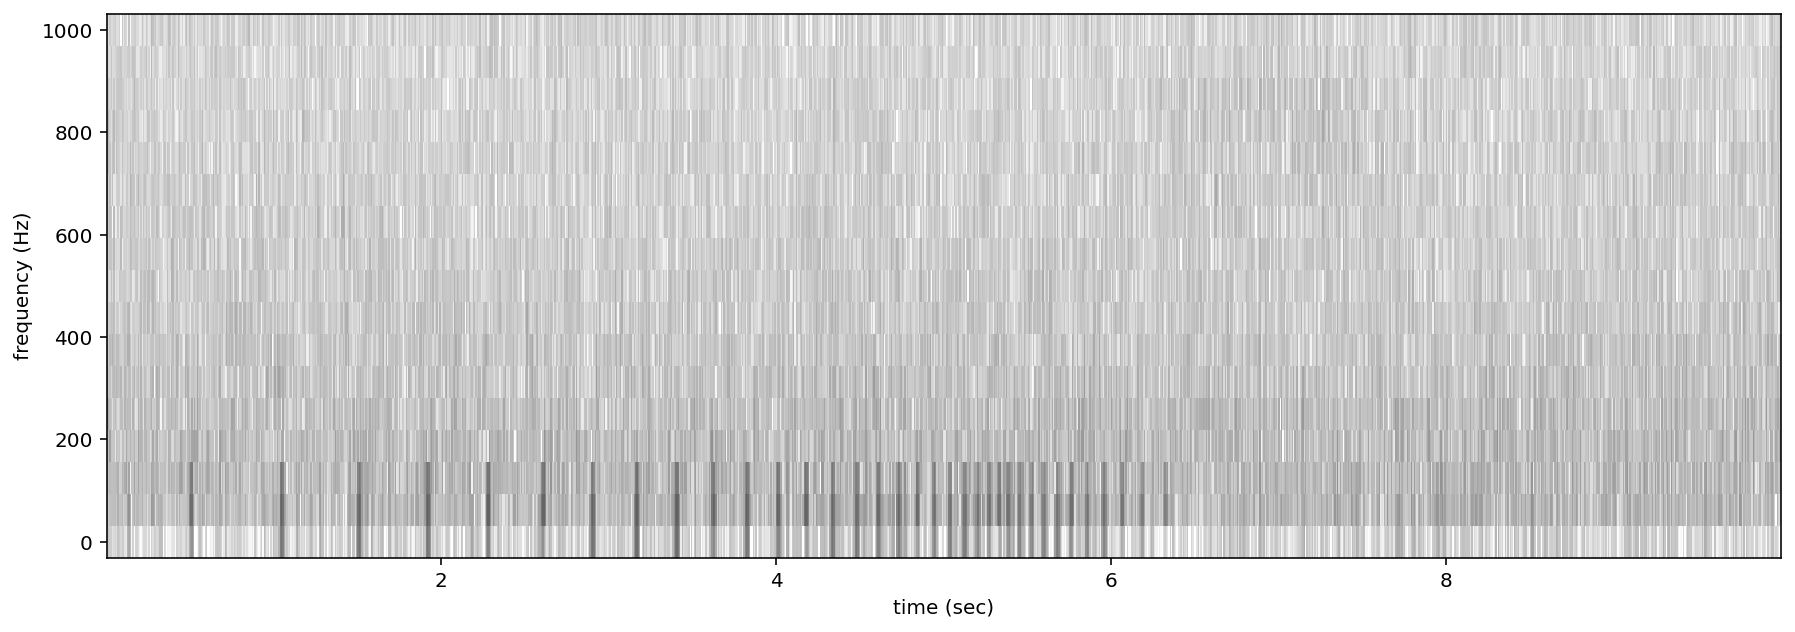

In [41]:
#load the relevant audio
audio_clip_with_detection = Audio.from_file(f,offset=65,duration=10)

#create a spectrogram
spec = Spectrogram.from_audio(audio_clip_with_detection).bandpass(0,1000)

#plot the spectrogram
spec.plot()

#display the audio in a playable IPython object
from IPython import display
display.Audio(audio_clip_with_detection.samples,rate=audio_clip_with_detection.sample_rate)

we can clearly see the ruffed grouse drumming event in the spectrogram. If you have speakers or headphones with good low-frequency response, you can also hear the accellerating thumping of the ruffed grouse drumming display by clicking play on the audio player. 

## Analyze all files in the validation set
This will take a while because it requires analyzing 1120 minutes of audio. If you wish, you can instead run the commented out cell to load the results produced by running this cell. 

In [87]:
from tqdm import tqdm

In [104]:
#get a list of all files
files = glob('./ruffed_grouse_validation_set/audio/*/*/*.wav')

print(f"analyzing {len(files)} files")

all_results = []
for f in tqdm(files):
    all_results.append(analyze_file(f))
    
all_results_df = pd.concat(all_results)

analyzing 224 files


100%|██████████| 224/224 [07:56<00:00,  2.13s/it]


In [107]:
all_results_df.to_csv('saved_recognizer_outputs.csv')

uncomment the line below to load the previously computed outputs from the model (if you want to skip the analysis step above)

In [128]:
# all_results_df = pd.read_csv('saved_recognizer_outputs.csv')

## load labels for 1-minute clips
This table has a label for each minute of each 5-minute audio clip: 1 if it contains ruffed grouse drumming and 0 otherwise. It was generated from the raven selection tables included in `./validation-set/annotations`. To see the details on how the table was generated, scroll to the bottom of this notebook. 

In [178]:
label_df_1min = pd.read_csv('./1minute_presence_absence_labels.csv').set_index('file')
label_df_1min.head()

,1,2,3,4,5
file,,,,,
./validation_set/audio/20200425/LSD-0021/20200425_114000_0s-300s.wav,0.0,0.0,0.0,0.0,0.0
./validation_set/audio/20200425/LSD-0019/20200425_114000_0s-300s.wav,0.0,0.0,0.0,0.0,0.0
./validation_set/audio/20200425/LSD-0010/20200425_114000_0s-300s.wav,0.0,0.0,0.0,0.0,0.0
./validation_set/audio/20200425/LSD-0028/20200425_114000_0s-300s.wav,0.0,1.0,1.0,1.0,1.0
./validation_set/audio/20200425/LSD-0017/20200425_114000_0s-300s.wav,0.0,0.0,0.0,0.0,0.0


## evaluate the performance of the recognizer
Now that we have created 1-minute labels on the validation set and have generated detections with the automated recognizer, we can evaluate its performance using precision, recall, and f1 score (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html) for definitions).



In [126]:
from sklearn.metrics import precision_recall_fscore_support

Summarize detection/non-detection data (1 or 0) on 1-minute clips for the automated recognizer scores. 

In [169]:
all_results_df['minute']=(all_results_df.window_start_t//60 + 1).astype(int)

detection_1min = [[len(all_results_df[(all_results_df.path==file) &  (all_results_df.minute==m)])>0  
                   for m in [1,2,3,4,5]]
                  for file in label_df_1min.index]
detection_df_1min = pd.DataFrame(detection_1min,index=label_df_1min.index,columns=label_df_1min.columns)

flatten the labels and values to 1-d arrays

In [172]:
labels = [l for row in label_df_1min.values for l in row]
detections = [d for row in detection_df_1min.values for d in row]

#### Calculate metrics

In [177]:
precision,recall,f1,support  = precision_recall_fscore_support(labels,detections)
print(f'precision for ruffed grouse presence: {precision[1]:0.2f}')
print(f'recall for ruffed grouse presence: {recall[1]:0.2f}')
print(f'F1 score for ruffed grouse presence: {f1[1]:0.2f}')

precision for ruffed grouse presence: 0.71
recall for ruffed grouse presence: 0.78
F1 score for ruffed grouse presence: 0.74







### Extra details: creating 1-minute labels from Raven annotations
You can use the pre-generated set of 1-minute labels, but if you want to see how they are created from the Raven annotation folders, use the code below

In [120]:
from opensoundscape.annotations import BoxedAnnotations
all_labels = []
for f in files:
    annotation_file = f.replace('audio','annotations').replace('.wav','.Table.1.selections.txt')

    try:
        ann = BoxedAnnotations.from_raven_file(annotation_file, annotation_column='Species')
    except:
        #annotation file doesn't exist, so this file has no labels
        all_labels.append([0]*5)
        continue

    
    if len(ann.df)<1:
        #annotation file contains no annotations
        all_labels.append([0]*5)
        continue
    
    minute_labels = ann.one_hot_clip_labels(
        clip_duration=60, #separate into one label per 60 seconds of audio
        clip_overlap=0,  #with no overlap between clips
        classes=None, #include all classes (we only have Rugr annotations in these files)
        min_label_overlap=0, #any overlapping annotations, regardless of how much overlap, are included
        full_duration=60*5 #length of entire audio file
    )
    

    all_labels.append(list(minute_labels.Rugr.values))


how many 1-minute clips are labeled as having ruffed grouse drumming?

In [121]:
np.sum(all_labels)

37.0

In [122]:
#make sure each 1 minute clip has a label
assert len([f for x in all_labels for i in x ]) == 1120

save labels to a table

In [180]:
label_df_1min = pd.DataFrame(all_labels,index=files,columns=[1,2,3,4,5])
label_df_1min.index.name='file'
label_df_1min.to_csv('./1minute_presence_absence_labels.csv')